###Practica 2: Detección de Anomalias

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import precision_score, accuracy_score

In [58]:
dataTraining = pd.read_csv("estaturas.csv")
dataTraining.head()

,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


Text(0, 0.5, 'Edad')

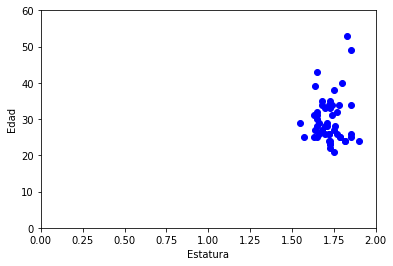

In [59]:
plt.scatter(dataTraining["Estatura(metros)"],dataTraining["Edad(años)"], marker="o", color = "b")
plt.xlim(0,2)
plt.ylim(0,60)
plt.xlabel("Estatura")
plt.ylabel("Edad")

Text(0, 0.5, 'Edad')

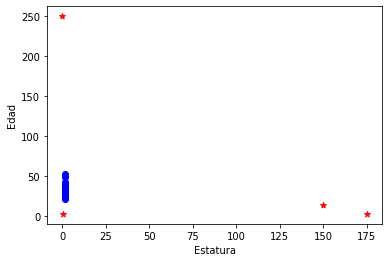

In [60]:
dataAnomalias = pd.read_csv("valtest_anomalias.csv")
#dataAnomalias.head()
dataAnomalias = pd.read_csv("valtest_anomalias.csv")
plt.scatter(dataTraining["Estatura(metros)"],dataTraining["Edad(años)"], marker="o", color = "b")
plt.scatter(dataAnomalias["Estatura"],dataAnomalias["Edad"], marker="*", color = "r")
plt.xlabel("Estatura")
plt.ylabel("Edad")

In [61]:
data_val_a, data_test_a = train_test_split(dataAnomalias, test_size = 0.50)
data_val_a = data_val_a.assign(label=1)
data_test_a = data_test_a.assign(label=1)

In [62]:
dataNormales = pd.read_csv("valtest_normales.csv")
dataNormales = dataNormales.assign(label=0)
dataNormales.columns = ['Estatura', 'Edad','label']
data_val_n, data_test_n = train_test_split(dataNormales, test_size = 0.50)

data_cval = data_val_a.append(data_val_n)  #data cross validation (con anomalias y valores normales)
data_tst = data_test_a.append(data_test_n) #data test (con anomalias y valores normales)

data_cv = data_cval[['Estatura', 'Edad']].copy()
data_cv_y = data_cval[['label']].copy()

data_test = data_tst[['Estatura', 'Edad']].copy()
data_test_y = data_tst[['label']].copy()

In [138]:
def estimacionGaussiana(dataset):
    media = np.mean(dataset, axis=0)
    desviacion = np.cov(dataset.T)
    return media, desviacion

def multivarianteGaussiana(dataset,media,desviacion):
    p = multivariate_normal(mean=media, cov=desviacion)
    return p.pdf(dataset)

def seleccionUmbral(probs,labels):
    umbral_seleccionado = 0
    f1_seleccionado = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):

        predictions = (probs < epsilon) 
        #print(predictions)
        f = f1_score(labels, predictions,average='binary')
        #print(f)
        #print('------')
        if f > f1_seleccionado:
            #print('----')
            f1_seleccionado = f
            umbral_seleccionado = epsilon
    
    return f1_seleccionado, umbral_seleccionado
  

In [139]:
#Utilizando el data training para obtener los parametros de la distribción y probabilidad de ocurrencia
media, desviacion = estimacionGaussiana(dataTraining)
p = multivarianteGaussiana(dataTraining,media,desviacion)

In [140]:
#valor optimo del umbral
p_cv = multivarianteGaussiana(data_cv,media,desviacion)
fscore, ep = seleccionUmbral(p_cv,data_cv_y)
print(ep)

0.0002235745708117539


In [141]:
#detectando anomalias 
anomaliasTraining = np.asarray(np.where(p < ep))
anomaliasTraining

array([], shape=(1, 0), dtype=int64)

In [143]:
pred_Tr = np.zeros(dataTraining.shape[0])
pred_Tr[anomaliasTraining]=1
pred_Tr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

Predicción con el Data Test

In [144]:
data_test

,Estatura,Edad
1,175.10,2.5
3,150.00,14.0
5,1.76,32.0
1,1.80,27.0
0,1.82,25.0
7,1.61,31.0


In [145]:
#Utilizando el data test
pt = multivarianteGaussiana(data_test,media,desviacion)
anomaliasTest = np.asarray(np.where(pt < ep))
anomaliasTest

array([[0, 1]])

In [146]:
pred_t = np.zeros(data_test.shape[0])
pred_t[anomaliasTest]=1
pred_t

array([1., 1., 0., 0., 0., 0.])

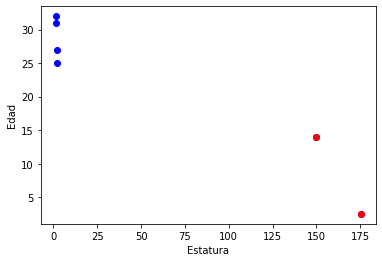

In [148]:
plt.figure()
plt.xlabel('Estatura')
plt.ylabel('Edad')
plt.plot(data_test.iloc[:,0],data_test.iloc[:,1],'bo')
plt.plot(data_test.values[anomaliasTest,0],data_test.values[anomaliasTest,1],'ro')
plt.show()

accuracy:  1.0
precision:  1.0
f1 score:  1.0


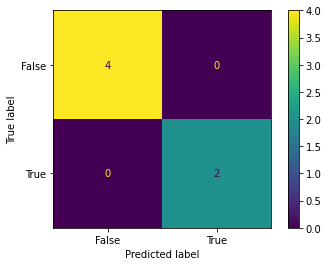

In [137]:
print('accuracy: ',accuracy_score(data_test_y, pred_t))
print('precision: ', precision_score(data_test_y, pred_t))
print('f1 score: ', f1_score(data_test_y, pred_t))
confusion_matrix = metrics.confusion_matrix(data_test_y, pred_t)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()